In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


# Importing Required Modules 

In [2]:
import pandas as pd
import cv2 as cv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Model Hyper parameters

In [3]:
train_path = "/kaggle/input/extracting-attributes-from-fashion-images-2/train"
BATCH_SIZE = 64
EPOCHS = 7
INPUT_SHAPE = 224
LR = 0.0000001

# Data Importing

In [4]:
# training data
train_df = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-2/train.csv")
train_df

,file_name,label
0,Image_train_00001.jpg,0
1,Image_train_00002.jpg,1
2,Image_train_00003.jpg,0
3,Image_train_00004.jpg,0
4,Image_train_00005.jpg,0
...,...,...
18386,Image_train_18387.jpg,1
18387,Image_train_18388.jpg,2
18388,Image_train_18389.jpg,1
18389,Image_train_18390.jpg,1


In [5]:
# testing data
test_df = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-2/sample_submission.csv")
test_df

,file_name,label
0,Image_test_00001.jpg,0
1,Image_test_00002.jpg,0
2,Image_test_00003.jpg,0
3,Image_test_00004.jpg,0
4,Image_test_00005.jpg,0
...,...,...
5746,Image_test_05747.jpg,0
5747,Image_test_05748.jpg,0
5748,Image_test_05749.jpg,0
5749,Image_test_05750.jpg,0


## Checking for Imbalance in the dataset

In [6]:
train_df.label.value_counts()

1    5384
2    4084
3    2008
4    1972
6    1925
5    1616
0    1402
Name: label, dtype: int64

In [7]:
test_df.label.value_counts()

0    5751
Name: label, dtype: int64

In [8]:
train_df.label.unique()

array([0, 1, 2, 3, 5, 4, 6])

In [9]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df.label.to_numpy()),
                                                 y=train_df.label.to_numpy()))
class_weights

[1.8739555736702669,
 0.4879802589683719,
 0.6433118791101161,
 1.3084092202618098,
 1.3322949869603014,
 1.6257956152758133,
 1.3648237476808904]

In [10]:
weights = {x:y for x,y in enumerate(class_weights)}
weights

{0: 1.8739555736702669,
 1: 0.4879802589683719,
 2: 0.6433118791101161,
 3: 1.3084092202618098,
 4: 1.3322949869603014,
 5: 1.6257956152758133,
 6: 1.3648237476808904}

# Visualization the dataset

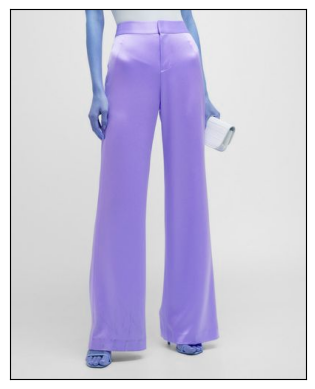

In [11]:
from matplotlib import pyplot as plt

train_files = os.listdir(train_path)
img = cv.imread(train_path+"/"+train_files[1])
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

# Creating Data Pipelines

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_df['label'] = test_df['label'].astype(str)
train_df['label'] = train_df['label'].astype(str)

datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode = "nearest",
    validation_split=0.15
)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/extracting-attributes-from-fashion-images-2/train",
    x_col="file_name",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=(INPUT_SHAPE,INPUT_SHAPE))

valid_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/extracting-attributes-from-fashion-images-2/train",
    x_col="file_name",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=(INPUT_SHAPE,INPUT_SHAPE))



Found 15633 validated image filenames belonging to 7 classes.
Found 2758 validated image filenames belonging to 7 classes.


In [13]:
test_datagen=ImageDataGenerator(rescale=1./255.)



test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="/kaggle/input/extracting-attributes-from-fashion-images-2/test",
x_col="file_name",
y_col="label",
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="sparse",
target_size=(INPUT_SHAPE,INPUT_SHAPE))


Found 5751 validated image filenames belonging to 1 classes.


# Creating the Deep learning model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
import tensorflow as tf
from keras.applications import VGG16
from tensorflow.python.keras import regularizers

# conv_base = VGG16(weights="imagenet",
#                  include_top=False,
#                  input_shape=(INPUT_SHAPE,INPUT_SHAPE,3)) # 244


conv_base = tf.keras.applications.mobilenet.MobileNet( include_top=False,
                                                           input_shape=(224, 224,3),
                                                           weights='imagenet')    


model = Sequential()

model.add(conv_base)
# conv_base.trainable = False

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Dense(7, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(lr=LR),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

17225924/17225924 [==============================] - 0s 0us/step


In [15]:
# mobile = tf.keras.applications.mobilenet.MobileNet( include_top=False,
#                                                            input_shape=(224, 224,3),
#                                                            pooling='max', weights='imagenet',
#                                                            alpha=1, depth_multiplier=1,dropout=.5)                                                          
# x=mobile.layers[-1].output
# x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
# predictions=Dense (7, activation='softmax')(x)

# model = tf.keras.Model(inputs=mobile.input, outputs=predictions)    
# for layer in model.layers:
#     layer.trainable=True
# model.compile(tf.keras.optimizers.Adamax(lr=LR), loss='categorical_crossentropy', metrics=['accuracy'])

# checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath="/kaggle/working/model/", monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='auto', save_freq='epoch', options=None)
# lr_adjust=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=0, mode="auto",
#     min_delta=0.00001,  cooldown=0,  min_lr=0) 
# callbacks=[checkpoint, lr_adjust]


In [16]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7)                 9

# Training

In [18]:
! mkdir /kaggle/working/model/

checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath="/kaggle/working/model/CNN.h5", 
                                              monitor='val_accuracy', 
                                              verbose=0, 
                                              save_best_only=True,
                                              save_weights_only=False, 
                                              mode='auto', 
                                              save_freq='epoch', 
                                              options=None)

Epoch 1/7
244/244 [==============================] - 351s 1s/step - loss: 1.0063 - accuracy: 0.5536 - val_loss: 1.5481 - val_accuracy: 0.4055
Epoch 2/7
244/244 [==============================] - 264s 1s/step - loss: 0.7454 - accuracy: 0.6471 - val_loss: 1.1686 - val_accuracy: 0.4891
Epoch 3/7
244/244 [==============================] - 268s 1s/step - loss: 0.6899 - accuracy: 0.6669 - val_loss: 1.6105 - val_accuracy: 0.3837
Epoch 4/7
244/244 [==============================] - 282s 1s/step - loss: 0.6469 - accuracy: 0.6838 - val_loss: 1.1966 - val_accuracy: 0.4967
Epoch 5/7
244/244 [==============================] - 275s 1s/step - loss: 0.6089 - accuracy: 0.7017 - val_loss: 1.4078 - val_accuracy: 0.4935
Epoch 6/7
244/244 [==============================] - 268s 1s/step - loss: 0.5818 - accuracy: 0.7124 - val_loss: 1.7556 - val_accuracy: 0.3289
Epoch 7/7
244/244 [==============================] - 268s 1s/step - loss: 0.5558 - accuracy: 0.7251 - val_loss: 1.1430 - val_accuracy: 0.5411
dict_k

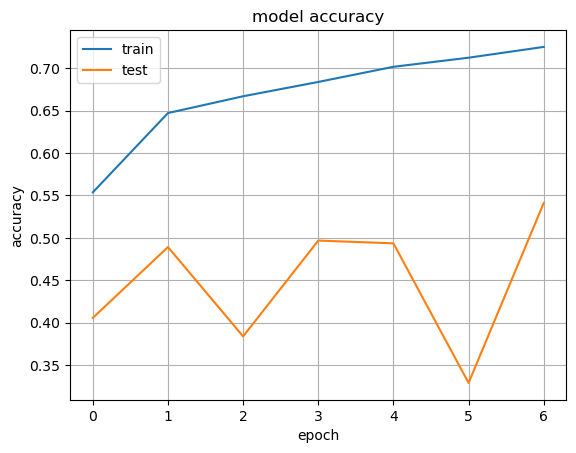

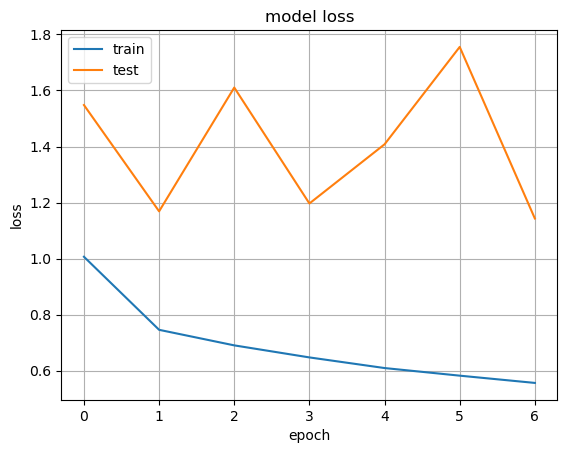

In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                   callbacks=[checkpoint],
                   class_weight=weights)



print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [20]:
model = tf.keras.models.load_model("/kaggle/working/model/CNN.h5")

# Testing

In [21]:
valid_generator.reset()
model.evaluate(valid_generator,
steps=STEP_SIZE_TEST)

89/89 [==============================] - 39s 423ms/step - loss: 1.1678 - accuracy: 0.5359


[1.16779363155365, 0.535895586013794]

In [22]:
test_generator.reset()
pred=model.predict(test_generator)

90/90 [==============================] - 50s 548ms/step


In [23]:
y_pred=np.argmax(pred,axis=1)
y_pred

array([2, 2, 2, ..., 2, 1, 1])

In [24]:
from sklearn.metrics import confusion_matrix,accuracy_score
test_df['label'] = test_df['label'].astype(int)

cm=confusion_matrix(test_df.label, y_pred)
print(cm)

accuracy_score(test_df.label.to_numpy(), y_pred)
# tn,fp,fn,tp = confusion_matrix(test_df.label, y_pred).ravel()

[[ 312 1058  743  720  796 1187  935]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]


0.05425143453312467

# Creating submission.csv

In [25]:
filenames=test_generator.filenames
results=pd.DataFrame({"file_name":filenames,
                      "label":y_pred})
results.to_csv("submission.csv",index=False)

In [26]:
# test_df['label'] = test_df['label'].astype(int)

# Reasons for low testing accuracy 
**Problem**: Although the training and testing data belong to the same dataset, the split in the dataset is very different, training data has about 1402 belonging to class 0 and the testing data has all the data belonging to class 0. Inorder to make a model that generalizes well on the dataset we need atleast a minimun of 5000 samples per class.

**Solution 1**: Adding more data in the dataset would lead to better learning of the model and would remove any bias in the dataset. But this is not possible in our case.

**Solution 2**: If adding data is not an option then using a pre-trained model could lead to better generalization. This is because pre trained models are trained for good feature extration. This should work for our use case but from what I have learned while training the model, Due to the low amount of class 0 data in the dataset the pretrained model is also not able to learn well even though it generalizes well.
